# Adjective Representation PCA

Let's look at the representations induced in a noun after being described by various adjectives. 

We will sample adjectives from Webster's dictionary, and we will use a pre-defined single-token noun/prompt for now. 

An exciting extension for understanding the **temporality** of emotion in LLMs by examining structure in the representations of the noun after T tokens have passed. Will the strength of the "emotion signals" dissapate over time? Will we see commonality in the representations when projected along an "emotional access" (PCA dimension)? 

In [15]:
# Imports 
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

from sklearn.decomposition import PCA

## Load Mistral-7b

Best 7b parameter on the market. For a rough sense of how "smart" Mistral-7b is, 
it's 8 x 7b mixture-of-experts cousin has the same ELO (1118) as GPT-3.5-Turbo on HuggingFace. 
For context, GPT-4 has an ELO of 1253. 

Hopefully being a relatively "intelligent" model will make it represent emotions more
clearly/reliably. If these results are promising, we can always re-run them on
the 8 x 7b Mistral variant. 

In [16]:
# load Mistral-7b -- one of the smartest 7b model on the market 
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1").to('cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load Webster's Dictionary

We are going to pull the [Webster's Unabridged Dictionary](https://www.gutenberg.org/ebooks/29765)
from project Gutenberg and parse it to find adjectives. 

In [17]:
# download https://www.gutenberg.org/ebooks/29765.txt.utf-8 using requests
# check if Websters_English_Dictionary.txt exists
import os 
import requests

if not os.path.exists('Websters_English_Dictionary.txt'): 
    url = "https://www.gutenberg.org/ebooks/29765.txt.utf-8"
    response = requests.get(url)
    text = response.text
    print("Length of text response: ", len(text))

    # write to external text file 
    with open("Websters_English_Dictionary.txt", "w") as file:
        file.write(text)
else: 
    # load the text file
    print("Loading text file")
    with open("Websters_English_Dictionary.txt", "r") as file:
        text = file.read()

Loading text file


In [18]:
# regular expression to find all lines that have any number of capital letters 
# followed by any number of white space characters followed by the end of line. 
import re
pattern = r"[A-Z]+\s*$\n[^,]+, a\."
matches = re.findall(pattern, text, re.MULTILINE)
print("Number of adjective entry matches: ", len(matches))

Number of adjective entry matches:  25866


In [19]:
# picking out just the adjective
pattern = r"[A-Z]+\n"
adjectives = [re.findall(pattern, x, re.MULTILINE)[0][:-1] for x in matches]

adjectives = [x.lower() for x in adjectives] # make lowercase

adjectives[:15] # sanity check 

['abactinal',
 'abandoned',
 'abased',
 'abatable',
 'abatised',
 'abbatial',
 'abbatical',
 'abbreviate',
 'abbreviated',
 'abbreviatory',
 'abderian',
 'abdicable',
 'abdicant',
 'abdicative',
 'abditive']

## Dataset Generation 

Let's format it as something like a statement of fact about "James"

```
Bob is extremely abderian. Therefore, Bob 
                   {adjective}       {examine these representations}
```

In [20]:
# template_string = "Alice is extremely {}. Therefore, Alice"
template_string = "Bob is extremely {}. Therefore, Bob"

# generate a sentence for each adjective
sentences = [template_string.format(x) for x in adjectives]

# tokenize the sentences 
tokenizer.pad_token = tokenizer.eos_token
input_ids = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=128)
input_ids.keys()

dict_keys(['input_ids', 'attention_mask'])

In [21]:
input_ids['input_ids'].shape

torch.Size([25866, 16])

In [8]:
def get_bob_vals(past_kvs): 
    """
    Args: 
        `past_kvs`: model output['past_key_values'] from running a batch of 
        left-padded sentences through the model.

        Accepts `past_kvs`, a tuple of length NUM_LAYERS (32), each containing a 
        2-long tuple (for keys and values respectively), each containing a torch 
        Tensor of shape [batch, num_heads, seq_len, head_dim] (for values). 

    Returns: 
        `bob_kvs`: list of length BATCH_SIZE with some numpy arrays representing 
        of shape [num_layers, num_heads, head_dim]
    """

    # iterate thru batch size 
    BATCH_SIZE = past_kvs[0][1].shape[0]

    batch_bob_values = []
    for batch_el in range(BATCH_SIZE): 
        # aggregate representations from across the layers 
        bob_numpy_arrays = []
        for layer in range(len(past_kvs)): 
            bob_layer_l_value = past_kvs[layer][1][batch_el, :, -1, :].detach().cpu().numpy()
            # print("Bob layer_l_value shape: ", bob_layer_l_value.shape)

            # unsqueeze on dimension zero
            bob_numpy_arrays.append(bob_layer_l_value[np.newaxis, ...])
        
        # merge on axis 0
        bob_numpy_arrays_conc = np.concatenate(bob_numpy_arrays, axis=0)
        # print("Bob numpy arrays shape (post-concatenation to combine layers)", bob_numpy_arrays_conc.shape)
        # bob_numpy_arrays now has shape n_layers = 32, n_heads = 8, embed_dim=128

        # add it to the list
        batch_bob_values.append(bob_numpy_arrays_conc)


    return batch_bob_values


In [9]:
# iterate thru input_ids
BATCH_SIZE = 33

past_values_bob = [] # list of length NUM_ADJECTIVES, each element is
                     # a numpy array of bob value reps of shape [num_layers=32, n_heads=8, embed_dim=128]

losses = []

print("Generating Bob representations...")
for i in tqdm(range(len(input_ids["input_ids"]) // BATCH_SIZE + 1)):
    batch_ids = input_ids["input_ids"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)
    # print("Batch ids shape (batch, ): ", batch_ids.shape)
    # print("Input string: ", tokenizer.decode(batch_ids[15, :]))
    # print(f"Final token: `{tokenizer.decode(batch_ids[0, -1:])}`")
    outputs = model.forward(batch_ids, return_dict=True, labels=batch_ids)
    # print("Output keys: ", outputs.keys())

    past_kvs = outputs['past_key_values']

    # print("Past key values (n_layers): ", len(past_kvs))
    # print("Batch size (reconstructed): ", past_kvs[0][1].shape[0])
    bob_numpy_arrays = get_bob_vals(past_kvs) # [batch_size], each a numpy array of shape [num_layers=32, n_heads=8, embed_dim=128]

    # let's add this to the past_values_bob 
    past_values_bob += bob_numpy_arrays


    # storing the loss value



Generating Bob representations...


100%|██████████| 784/784 [07:02<00:00,  1.86it/s]


In [10]:
print("Number of bob representations: ", len(past_values_bob))
print("Number of adjectives: ", len(adjectives))
print("Shape of individual bob value representation: ", past_values_bob[0].shape)
print("\t[num_layers=32, n_heads=8, embed_dim=128]")

Number of bob representations:  25866
Number of adjectives:  25866
Shape of individual bob value representation:  (32, 8, 128)
	[num_layers=32, n_heads=8, embed_dim=128]


In [11]:
# save to disk 
np.save("bob_representations.npy", past_values_bob)

In [22]:
# Load from disk 
past_values_bob = np.load("bob_representations.npy", allow_pickle=True)

## PCA on Bob Representations

Gotta flatten the past_values_bob[i] value reps, make a big ole matrix, and do 
PCA on it, and hope my computer doesn't explode. 

In [23]:
flat_past_values_bob = [x.flatten() for x in past_values_bob]
past_values_bob_matrix = np.array(flat_past_values_bob)
print("Past values bob matrix shape (num_adjectives, token_value_dim): ", past_values_bob_matrix.shape)

# save to disk 
np.save("bob_representations_flat.npy", past_values_bob_matrix)

Past values bob matrix shape (num_adjectives, token_value_dim):  (25866, 32768)


In [24]:
# Now we do pca
# load from disk 
past_values_bob_matrix = np.load("bob_representations_flat.npy")
print("past_value_bob_matrix shape: ", past_values_bob_matrix.shape)

past_value_bob_matrix shape:  (25866, 32768)


In [25]:
# doing pca
# Initialize PCA to keep the first 3 principal components
pca = PCA(n_components=3)

# Fit PCA on your data and transform it to get the 3-dimensional representation
transformed_data = pca.fit_transform(past_values_bob_matrix)

# transformed_data now has shape [N, 3], where N is the number of examples
print("Transformed data shape:", transformed_data.shape)
print("First 3-dimensional representation:", transformed_data[0])


Transformed data shape: (25866, 3)
First 3-dimensional representation: [14.846477   7.0009103  1.2679191]


## Plotly Interactive Scatter Plot

We will output this as an HTML file you can view with the browser to explore the 
data space. 

In [26]:
import plotly.graph_objects as go

# Create a list of colors that scales with the index i
colors = [f'rgb({i/len(transformed_data)*255}, {150}, {255 - i/len(transformed_data)*255})' for i in range(len(transformed_data))]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=transformed_data[:, 0],
    y=transformed_data[:, 1],
    z=transformed_data[:, 2],
    text=adjectives,  # Set the labels for each point
    mode='markers+text',  # Choose to have both markers and text
    marker=dict(
        size=5,
        color=colors,  # Set the color of each point
        opacity=0.8
    )
)])

# Customize the layout of the plot
fig.update_layout(
    title='Mistral 7b: PCA on Bob reps in "Bob is extremely {adjective}. Therefore {Bob}" sentences',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Export the plot as an HTML file
fig.write_html('bob_adjective_reps.html')

In [ ]:
bob_adjective_reps.html

In [27]:
# randomly sample 1000 adjective-representations pairs
import random
indices = random.sample(range(len(adjectives)), 1000)
adjectives_sample = [adjectives[i] for i in indices]
transformed_data_sample = transformed_data[indices]

# make nice plotly plot
fig = go.Figure(data=[go.Scatter3d(
    x=transformed_data_sample[:, 0],
    y=transformed_data_sample[:, 1],
    z=transformed_data_sample[:, 2],
    text=adjectives_sample,  # Set the labels for each point
    mode='markers',  # Choose to have both markers and text
    marker=dict(
        size=5,
        color=colors,  # Set the color of each point
        opacity=0.8
    )
)])

# Customize the layout of the plot
fig.update_layout(
    title='Mistral 7b: PCA on Bob reps in "Bob is extremely {adjective}. Therefore {Bob}" sentences',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Export the plot as an HTML file
fig.write_html('bob_adjective_reps_sample_1000.html')

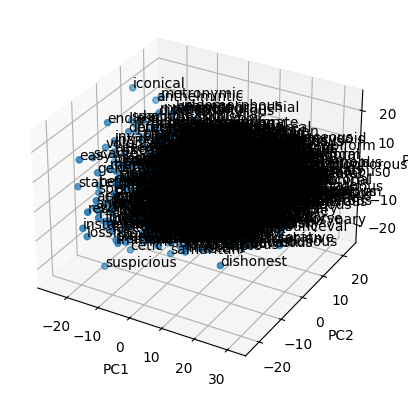

In [28]:
# standard matplotlib plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed_data_sample[:, 0], transformed_data_sample[:, 1], transformed_data_sample[:, 2])

for i in range(len(adjectives_sample)):
    ax.text(transformed_data_sample[i, 0], transformed_data_sample[i, 1], transformed_data_sample[i, 2], adjectives_sample[i])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

# save to disk